In [1]:
'''
 Created on: 
 Author: Trieu Phat Luu
 Contact: trieuphat.luu@bhge.com | tpluu2207@gmail.com
 Reference:
'''

'\n Created on: \n Author: Trieu Phat Luu\n Contact: trieuphat.luu@bhge.com | tpluu2207@gmail.com\n Reference:\n'

## Import packages

In [1]:
from __future__ import print_function
# Utils
# Auto reload module
%load_ext autoreload
%autoreload 2 
import warnings
warnings.filterwarnings('ignore')
import logging
import os, glob, sys, inspect
import time
from datetime import datetime
import math
import missingno as msno
import itertools as it

import json
from scipy.optimize import minimize
# from pyts.image import MarkovTransitionField, GramianAngularField
# Data helpers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Models
# from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.mixture import GaussianMixture as GMM
# Models selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.utils import class_weight
# Metrics
# Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
# Classification
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score, recall_score, confusion_matrix
# Tensorflow
import tensorflow as tf
from keras.utils import to_categorical

from keras import backend as K
from keras  import initializers
from keras import layers
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import Concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, model_from_json, Model
from keras.utils.vis_utils import plot_model
from keras import regularizers
# Prebuilt model
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
# Visualizaiton
from vis.utils import utils # Keras-vis packages
from vis.visualization import visualize_cam, visualize_saliency, overlay
from keras import activations
# Visualization-Plot
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import HTML, Image
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from PIL import Image as pil_image

Using TensorFlow backend.


## Import Custom Packages

In [29]:
# parent_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir))
parent_dir = os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir))
sys.path.append(parent_dir)
from Classes import FileStorageIOClass
from utils import get_varargin, get_obj_params
import utils

## Settings and Global Variables

## Input data

In [3]:
import pickle
from imblearn.over_sampling import SMOTE
def load_data(**kwargs):
    default_filename = 'mudlog_data/2019-08-05-lith_classification_data.pickle'
    pckl_filename = get_varargin(kwargs, 'filename', default_filename)
    with open(pckl_filename, 'rb') as fid:
        win_gaf = pickle.load(fid)
        lith_label = pickle.load(fid)
    X_train, X_test, y_train, y_test = train_test_split(win_gaf, lith_label, 
                                                        test_size = 0.25, random_state = 42)
#     Handle imbalance data by generating synthetic samples
#     sm = SMOTE(random_state=27, ratio=1.0)
#     X_train, y_train = sm.fit_sample(X_train, y_train)
#     X_test, y_test = sm.fit_sample(X_test, y_test)
    return X_train, X_test, y_train, y_test

In [4]:
def get_key(input_dict,search_val):
    for key,val in input_dict.items():
        if val == search_val:
            return key
def make_lith_dict():
    #     Number of classes and labels
    lith_list = ['shale', 'silt', 'coal', 'marl', 'lime', 'sand']    
    # Create a dictionary for lith_code
    permute_lith = it.combinations(lith_list, 2)
    lith_val = []
    for val in permute_lith:    
        lith_val.append(val)
    lith_dict = dict(zip(lith_val, np.arange(len(lith_val))))
    return lith_dict
lith_dict = make_lith_dict()
def data_statistic(X_train, X_test, y_train, y_test):
    print('X_train shape: {}'.format(X_train.shape))
    print('X_test shape: {}'.format(X_test.shape))
    print('y_train shape: {}'.format(y_train.shape))
    print('y_test shape: {}'.format(y_test.shape))
    lith_dict = make_lith_dict()
    print('Class indices and labels:')
    display(lith_dict)
#     Plot some random image with label
    nb_rows = 4
    nb_cols = 5
    fig = plt.figure(figsize = (10,10))
    for i in range(nb_rows * nb_cols):
        idx = np.random.random_integers(0,100,1)
        image = X_train[idx,:,:,0].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(nb_rows, nb_cols, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='viridis')  # cmap='gray' is for black and white picture.        
        plt.title('{}:{}'.format(int(y_train[idx]), get_key(lith_dict, y_train[idx])))
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots    
    plt.show()
#     Plot label distribution
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(121)
    n, bins, patches = plt.hist(x=y_train, bins=30, color='#0504aa',
                                alpha=0.7, rwidth=1)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Train Set')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    
    ax = fig.add_subplot(122)
    n, bins, patches = plt.hist(x=y_test, bins=30, color='#0504aa',
                                alpha=0.7, rwidth=1)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Test Set')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    

In [5]:
X_train, X_test, y_train, y_test = load_data()

X_train shape: (1163, 28, 28, 1)
X_test shape: (388, 28, 28, 1)
y_train shape: (1163,)
y_test shape: (388,)
Class indices and labels:


{('shale', 'silt'): 0,
 ('shale', 'coal'): 1,
 ('shale', 'marl'): 2,
 ('shale', 'lime'): 3,
 ('shale', 'sand'): 4,
 ('silt', 'coal'): 5,
 ('silt', 'marl'): 6,
 ('silt', 'lime'): 7,
 ('silt', 'sand'): 8,
 ('coal', 'marl'): 9,
 ('coal', 'lime'): 10,
 ('coal', 'sand'): 11,
 ('marl', 'lime'): 12,
 ('marl', 'sand'): 13,
 ('lime', 'sand'): 14}

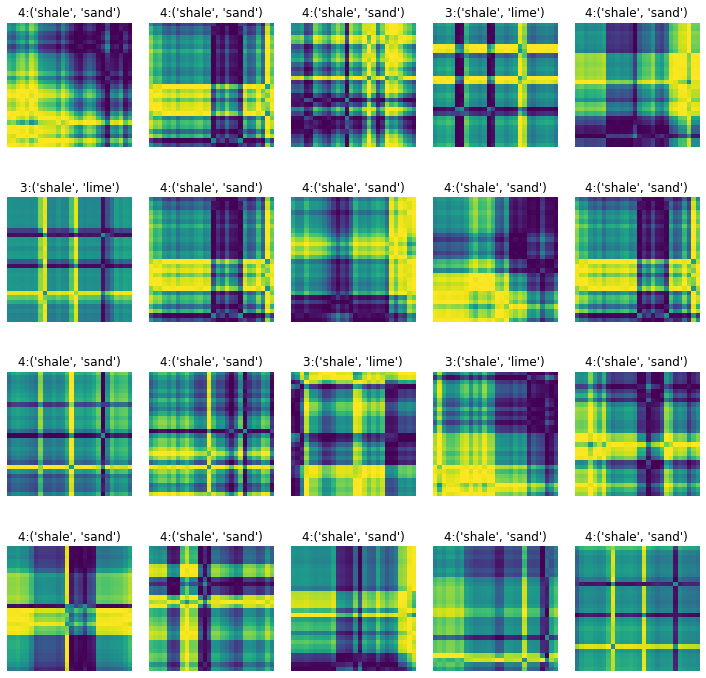

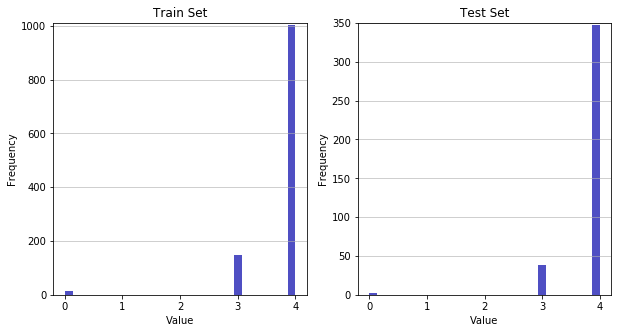

In [6]:
data_statistic(X_train, X_test, y_train, y_test)

In [7]:
_,img_rows, img_cols, img_ch = X_train.shape
img_size = (img_rows, img_cols)
nb_classes = 15

In [8]:
# Covert to one hot encoder
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

## Design Model

In [4]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [5]:
# Creating a Sequential Model and adding the layers
# input_shape = (img_rows, img_cols, img_ch)
input_shape = (27,27,3)
nb_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax', name = 'predictions'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

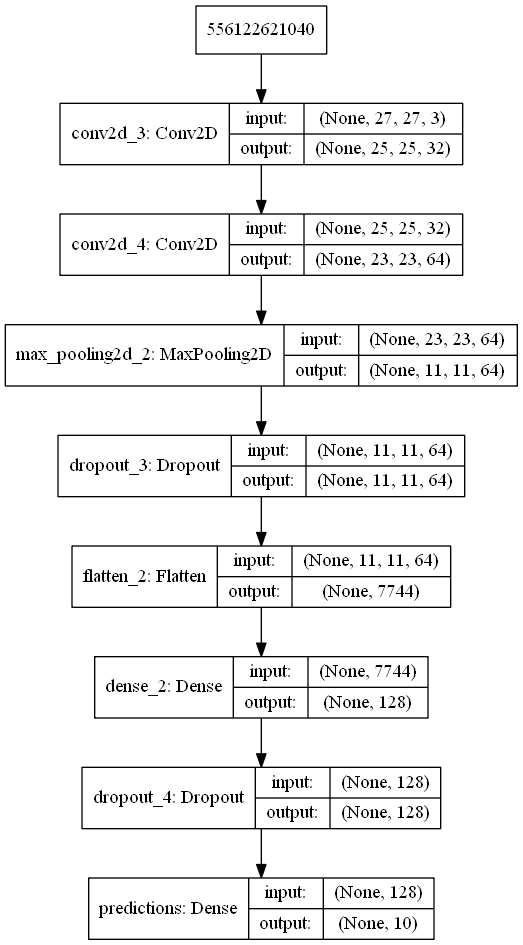

In [10]:
model.summary()
plot_model(model, show_shapes = True)
plot_model(model, show_shapes = True, to_file = 'TSC_VGG_Model.png')
# Plot model graph
Image(filename='TSC_VGG_model.png')

# Training

In [11]:
# Train model
# DEFINE
# Defined directories
logdirs = {'logModel': 'logModels', 'figdir': 'images'}
for key, val in logdirs.items():
    if not os.path.exists(val):
        os.makedirs(val)
todaystr = datetime.today().strftime('%Y%m%d')       
modelName = todaystr + '-MTSCVGG_preTrained'
jsonFile = os.path.join(logdirs['logModel'],modelName + '-json.json')
weightFile = os.path.join(logdirs['logModel'],modelName + '-weights.h5')
histFile = os.path.join(logdirs['logModel'],modelName + '-hist.pckl')
ckptsFile = os.path.join(logdirs['logModel'],modelName + '-ckpts.h5')

batch_size = 64
nb_epoch = 5

In [12]:
import inspect
import pickle
def saveHistory(histFile, histInput):
    # ==== BEGIN ====
    print('RUNNING: %s' % inspect.stack()[0][3])
    f = open(histFile, 'wb')
    pickle.dump(histInput, f)
    f.close()    
    # ==== END ====
    print('DONE: %s' % inspect.stack()[0][3])
# =============================================================================
def loadHistory(histInputfile):
    # ==== BEGIN ====
    print('RUNNING: %s' % inspect.stack()[0][3])
    f = open(histInputfile, 'rb')
    history = pickle.load(f)
    f.close()    
    # ==== END ====
    print('DONE: %s' % inspect.stack()[0][3])
    return history

In [13]:
# Save Keras model structure to json and model weight to h5
def saveModel(model, inputDir = 'logModels', modelname = modelName):
    # ==== BEGIN ====
    print('Running: %s' % inspect.stack()[0][3])
    json_string = model.to_json()
    # Save model architecture in JSON file
    jsonFilename = os.path.join(inputDir, modelname + '-json.json')
    open(jsonFilename, 'w').write(json_string)
    # Save weights as HDF5
    weightFilename = os.path.join(inputDir, modelname + '-weights.h5')
    model.save_weights(weightFilename)
    print('Model structure and weights has been saved')
    print('json: %s' %jsonFilename)
    print('weights: %s' %weightFilename)
    # ==== END ====
    print('DONE: %s' % inspect.stack()[0][3])
# =============================================================================
# Load model
def loadModel(modelDir, modelName):    
    print('Running: %s' % inspect.stack()[0][3])
    # Load model architecture from JSON file
    jsonFile = os.path.join(modelDir, modelName + '-json.json');
    weightFile = os.path.join(modelDir, modelName + '-weights.h5');
    model = model_from_json(open(jsonFile).read())
    print('%s file is loaded' % jsonFile)
    # Load model weights from HDF5 file
    model.load_weights(weightFile)
    print('%s file is loaded' % weightFile)
    return model
    print('DONE: %s' % inspect.stack()[0][3])
# =============================================================================
from collections import defaultdict
def mergeDict(dict_list):
    dd = defaultdict(list)    
    for d in dict_list:
        for key, value in d.items():
            if not hasattr(value, '__iter__'):
                value = (value,)
            [dd[key].append(v) for v in value]
    return dict(dd)
# =============================================================================
# Save weights
def saveWeight(model, filename = weightFile):
    # ==== BEGIN ====
    print('Running: %s' % inspect.stack()[0][3])    
    # Save weights as HDF5
    model.save_weights(filename)
    print('Model weights have been Saved: %s' %filename)
    # ==== END ====
    print('DONE: %s' % inspect.stack()[0][3])   
# =============================================================================
def printTrainingTime(duration):
    hours, rem = divmod(duration, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total Training Time: {:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds)))
# =============================================================================

# Train-main()

In [14]:
from keras.models import load_model, model_from_json
from keras.callbacks import TensorBoard, ModelCheckpoint
# Load pre-trained model
if os.path.isfile(ckptsFile):
    print('Load checkpoints File: %s' % ckptsFile)
    model.load_weights(ckptsFile)
    print('Load History File: %s' % histFile)
    history = loadHistory(histFile)
else:
    history = {}
# Define checkpoint params
checkpoint = ModelCheckpoint(ckptsFile, monitor='loss', 
                             verbose=1, save_best_only=True, 
                             mode='min')
callbacks_list = [checkpoint]
# Start Training
start_time = time.time()    
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Deal with imbalanced training data
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
currHist = model.fit(X_train, Y_train, 
                         batch_size=batch_size, epochs=nb_epoch,
                         verbose=1, validation_data=(X_test, Y_test),
                         class_weight = class_weights,
                         callbacks = callbacks_list)#, callbacks=[tensorboard])
history = mergeDict([history, currHist.history])
saveHistory(histFile, history)    
duration = time.time() - start_time    
printTrainingTime(duration)
# Save model
saveModel(model)

Load checkpoints File: logModels\20190806-MTSCVGG_preTrained-ckpts.h5
Load History File: logModels\20190806-MTSCVGG_preTrained-hist.pckl
RUNNING: loadHistory
DONE: loadHistory
Instructions for updating:
Use tf.cast instead.
Train on 1163 samples, validate on 388 samples
Epoch 1/5
1163/1163 [==============================] - 2s 2ms/step - loss: 0.0070 - acc: 0.9974 - val_loss: 0.2962 - val_acc: 0.9588

Epoch 00001: loss improved from inf to 0.00703, saving model to logModels\20190806-MTSCVGG_preTrained-ckpts.h5
Epoch 2/5
1163/1163 [==============================] - 2s 1ms/step - loss: 0.0018 - acc: 0.9991 - val_loss: 0.2914 - val_acc: 0.9588

Epoch 00002: loss improved from 0.00703 to 0.00181, saving model to logModels\20190806-MTSCVGG_preTrained-ckpts.h5
Epoch 3/5
1163/1163 [==============================] - 2s 1ms/step - loss: 7.8437e-04 - acc: 1.0000 - val_loss: 0.2632 - val_acc: 0.9665

Epoch 00003: loss improved from 0.00181 to 0.00078, saving model to logModels\20190806-MTSCVGG_pr

# Evaluate model

RUNNING: loadHistory
DONE: loadHistory


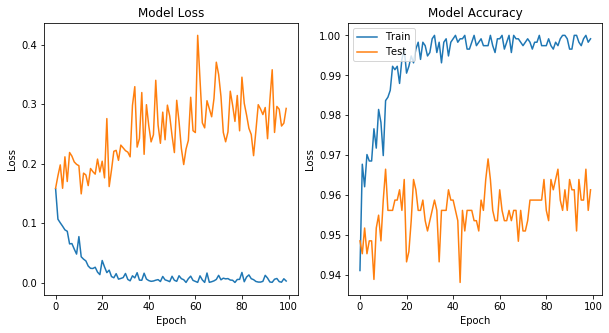

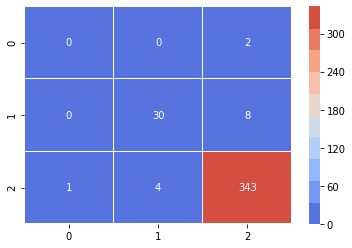

In [15]:
history = loadHistory(histFile)
# Plot
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
 # Annotation
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

ax = fig.add_subplot(122)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
 # Annotation
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.show()
_,hist_filename = os.path.split(histFile)
figFile = os.path.join(logdirs['figdir'], hist_filename.replace('-hist.pckl','-loss.png'))
fig.savefig(figFile, dpi = 400, bbox_inches = 'tight')

# Confustion Matrix
Y_predict = model.predict(X_test)
Y_predict_label = np.argmax(Y_predict, axis = 1)    
Y_test_label = np.argmax(Y_test, axis = 1)    
cm = confusion_matrix(y_true = Y_test_label, 
                      y_pred = Y_predict_label)
sns.heatmap(cm, annot = True, linewidth = 0.2, 
            cmap = sns.color_palette("coolwarm", 10), fmt = 'd')

Evaluate Model:
Correction/Total: 373 / 388
388/388 [==============================] - 0s 1ms/step
Test score: 16.027341311739892
Test accuracy: 0.961340206185567
F1 Score: 0.9593303135922664
Recall Score: 0.961340206185567


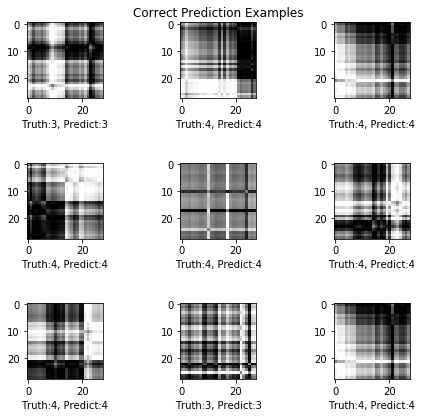

In [19]:
print('Evaluate Model:')
# model = loadModel(logdirs['logModel'], modelName)
# # For a multi-class classification problem
# model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
Y_predict = model.predict(X_test)
Y_predict_label = np.argmax(Y_predict, axis = 1)    
Y_test_label = np.argmax(Y_test, axis = 1)    
correct_prediction = np.nonzero(Y_test_label == Y_predict_label)[0]
incorrect_prediction = np.nonzero(Y_test_label != Y_predict_label)[0]
print('Correction/Total: {} / {}'.format(len(correct_prediction), len(Y_test)))
#    Evaluate model loss and accuracy
score = model.evaluate(X_test, Y_test, verbose = 1)
print('Test score:', score[0])
print('Test accuracy:', score[1]) 
# Compute F1 Score
f1 = f1_score(Y_test_label, Y_predict_label, average = 'weighted')
print('F1 Score: {}'.format(f1))
# Recall Score
recall = recall_score(Y_test_label, Y_predict_label, average = 'weighted')
print('Recall Score: {}'.format(recall))
#     Plot example prediction
fig1 = plt.figure(figsize = (6,6))    
for i, idx in enumerate(correct_prediction[np.random.random_integers(0,100,9)]):
    plt.subplot(3,3,i+1)
    plt.tight_layout();
    if i == 1:
        plt.title('Correct Prediction Examples')
    plt.imshow(X_test[idx].reshape(img_rows, img_cols),
               cmap = 'gray')
    plt.xlabel("Truth:{}, Predict:{}".format(Y_test_label[idx],
                                    Y_predict_label[idx]))

(0.0, 360.0)

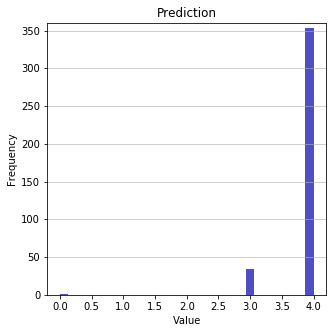

In [17]:
fig = plt.figure(figsize = (5,5))
n, bins, patches = plt.hist(x=Y_predict_label, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Prediction')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# Feature Visualization

Grad-CAM map for shale_sand


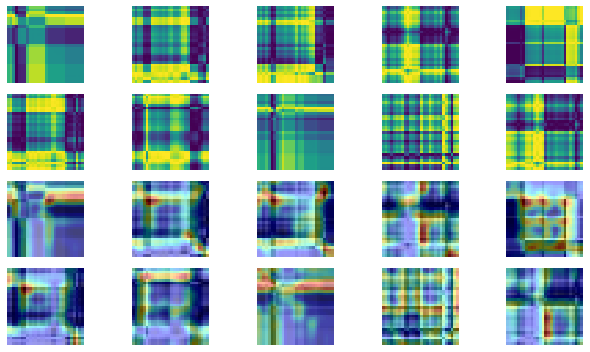

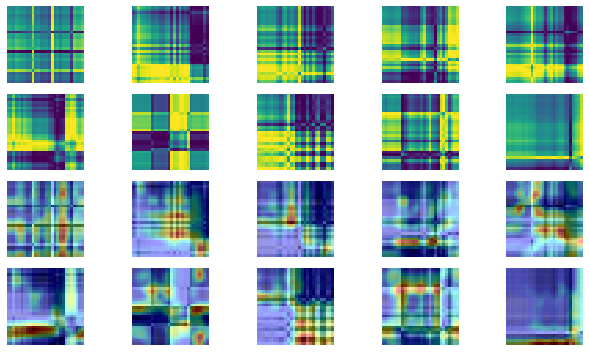

In [163]:
# Visualizaiton
from vis.utils import utils # Keras-vis packages
from vis.visualization import visualize_cam, visualize_saliency, overlay
from keras import activations
import matplotlib.cm as cm
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

cat3 = np.where(Y_predict_label == 3)
cat4 = np.where(Y_predict_label == 4)
sel_cat3 = np.random.choice(cat3[0], size = 10, replace = False)
sel_cat4 = np.random.choice(cat4[0], size = 10, replace = False)
sel_cat = np.append(sel_cat3, sel_cat4)

nb_rows = 4
nb_cols = 5
fig = plt.figure(figsize = (10,5))
lith_code = 3
for i in np.arange(10):
    img = X_test[sel_cat3[i]]
    cam = visualize_cam(model, layer_idx, filter_indices=lith_code, 
                              seed_input=img, backprop_modifier='guided')        
    jet_heatmap = np.uint8(cm.jet(cam)[...,:3]*255)
    ax = fig.add_subplot(nb_rows, nb_cols, i+1)
    plt.imshow(img.reshape(img_rows,img_cols), cmap = 'viridis')
    plt.axis('off')
    plt.tight_layout()
    
    ax = fig.add_subplot(nb_rows, nb_cols, i+11)
    plt.imshow(img.reshape(img_rows,img_cols), cmap = 'gray')
    plt.imshow(jet_heatmap, alpha=0.4, cmap = 'jet')
    plt.axis('off')
    plt.tight_layout();

lith_str = '_'.join(get_key(lith_dict,lith_code))
figFile = os.path.join('images', 'CAM-map for {}.png'.format(lith_str))
fig.savefig(figFile, dpi = 400, bbox_inches = 'tight')

lith_code = 4
fig = plt.figure(figsize = (10,5))
print('Grad-CAM map for {}'.format('_'.join(get_key(lith_dict,4))))
for i in np.arange(10):
    img = X_test[sel_cat4[i]]
    cam = visualize_cam(model, layer_idx, filter_indices=lith_code, 
                              seed_input=img, backprop_modifier='guided')        
    jet_heatmap = np.uint8(cm.jet(cam)[...,:3]*255)
    ax = fig.add_subplot(nb_rows, nb_cols, i+1)
    plt.imshow(img.reshape(img_rows,img_cols), cmap = 'viridis')
    plt.axis('off')
    plt.tight_layout()
    ax = fig.add_subplot(nb_rows, nb_cols, i+11)    
    plt.imshow(img.reshape(img_rows,img_cols), cmap = 'gray')
    plt.imshow(jet_heatmap, alpha=0.4, cmap = 'jet')
    plt.axis('off')
    plt.tight_layout();    
    
lith_str = '_'.join(get_key(lith_dict,lith_code))
figFile = os.path.join('images', 'CAM-map for {}.png'.format(lith_str))
fig.savefig(figFile, dpi = 400, bbox_inches = 'tight')


In [40]:
print(model.layers[2])
# utils.show_obj_params(model.input)
activation_model = Model(inputs = model.input,
                               outputs = model.layers[2].output)
layer_activation = activation_model.predict(np.expand_dims(X_test[sel_cat3[0]], axis = 0))
print(layer_activation.shape)

(1, 12, 12, 64)


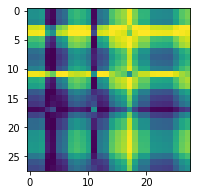

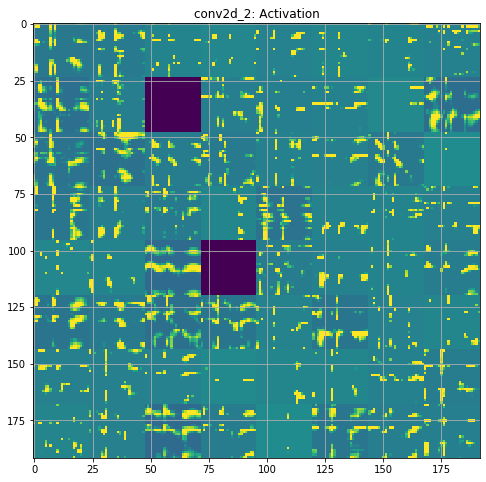

In [56]:
sel_layer = model.layers[1]
activation_model = Model(inputs = model.input,
                               outputs = sel_layer.output)
sel_img = X_test[sel_cat3[0]]
fig = plt.figure(figsize = (3,3))
plt.imshow(np.squeeze(sel_img, axis = -1), cmap = 'viridis')

layer_activation = activation_model.predict(np.expand_dims(sel_img, axis = 0))
n_features = layer_activation.shape[-1] # Number of features in the feature map
size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
images_per_row = 8
n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, # Displays the grid
                     row * size : (row + 1) * size] = channel_image
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title('{}: Activation'.format(sel_layer.name))
plt.grid(True)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

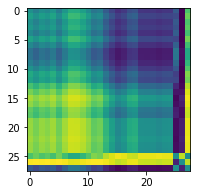

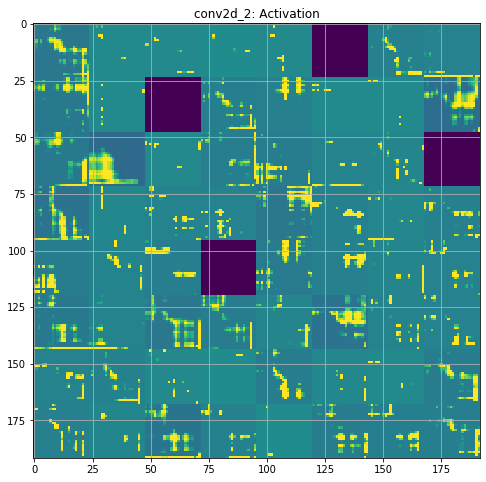

In [58]:
sel_layer = model.layers[1]
activation_model = Model(inputs = model.input,
                               outputs = sel_layer.output)
sel_img = X_test[sel_cat4[0]]
fig = plt.figure(figsize = (3,3))
plt.imshow(np.squeeze(sel_img, axis = -1), cmap = 'viridis')

layer_activation = activation_model.predict(np.expand_dims(sel_img, axis = 0))
n_features = layer_activation.shape[-1] # Number of features in the feature map
size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
images_per_row = 8
n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
display_grid = np.zeros((size * n_cols, images_per_row * size))
for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, # Displays the grid
                     row * size : (row + 1) * size] = channel_image
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title('{}: Activation'.format(sel_layer.name))
plt.grid(True)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [66]:
# plt.imshow(sel_layer.get_weights()[0][:, :, :, 0].squeeze(), cmap='gray')
check = sel_layer.get_weights()[0]
print(check.shape)

(3, 3, 32, 64)


## Search for images that maximize activation 

In [91]:
def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()




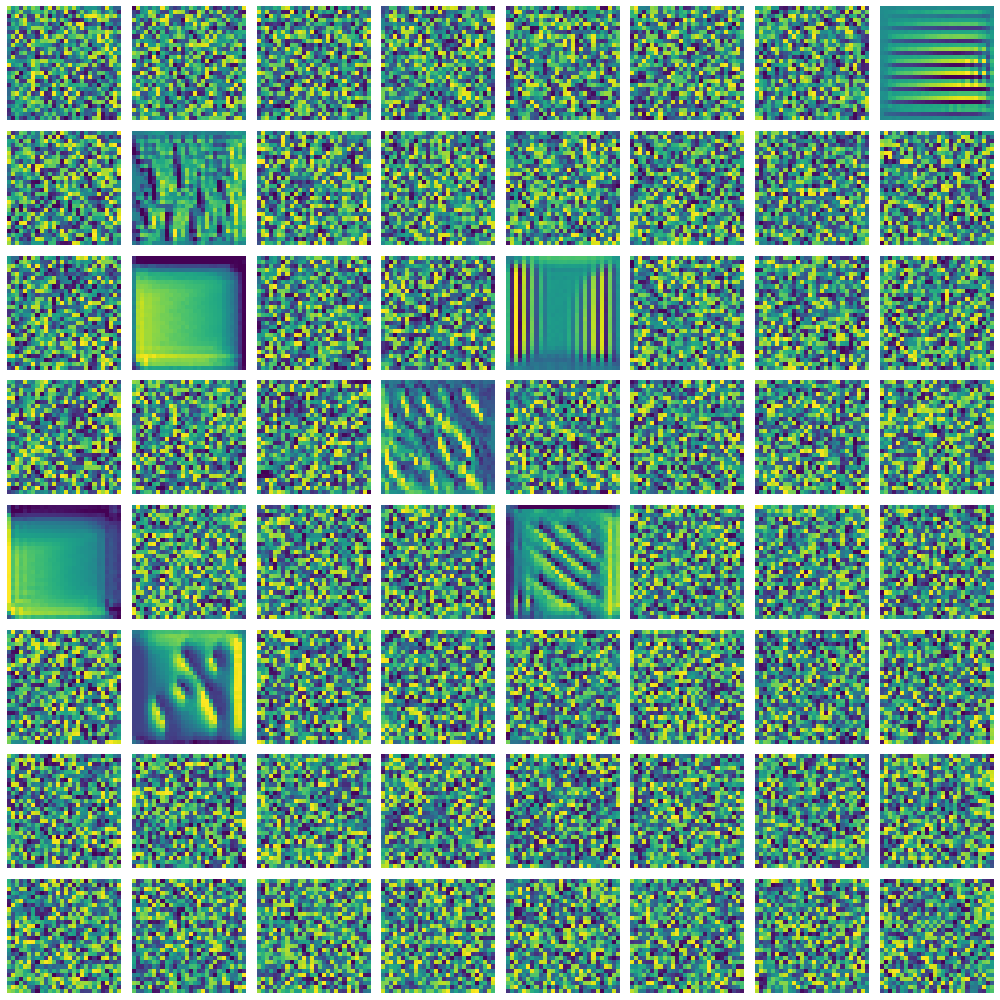

In [154]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'conv2d_2'
filter_index = 1  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
fig = plt.figure(figsize = (14,14))
nb_rows = 8
nb_cols = 8
output_index = 0
layer_activation = np.array([])
for axi, filter_index in enumerate(np.arange(64)):
#     loss = K.mean(model.output[:, output_index])
    loss = K.mean(layer_output[:, :, :, filter_index])
    input_img = model.inputs[0]
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.random.random((1,img_rows, img_cols,1)) * 20 + 128.
    step = 1.
    # run gradient ascent for 20 steps
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    img = deprocess_image(img)    
    fig.add_subplot(nb_rows, nb_cols, axi + 1)    
    plt.imshow(img.reshape(img_rows, img_cols))
    plt.axis('off')
    plt.tight_layout()
figFile = os.path.join('images', 'cnn_conv_layer_activation.png')
fig.savefig(figFile, dpi = 400, bbox_inches = 'tight')   

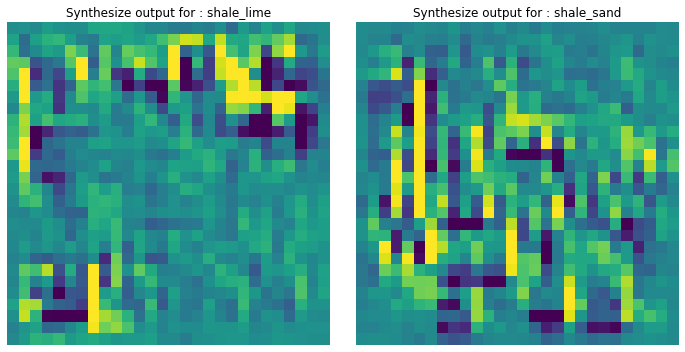

In [164]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'conv2d_2'
filter_index = 1  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
# loss = K.mean(layer_output[:, :, :, filter_index])
output_index = 0
fig = plt.figure(figsize = (10,5))
nb_rows = 1
nb_cols = 2
for axi, output_index in enumerate(np.array([3,4])):
    loss = K.mean(model.output[:, output_index])
    input_img = model.inputs[0]
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    input_img_data = np.random.random((1,img_rows, img_cols,1)) * 20 + 128.
    step = 1.
    # run gradient ascent for 20 steps
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    img = deprocess_image(img)
    fig.add_subplot(nb_rows, nb_cols, axi + 1)
    plt.imshow(np.squeeze(img,axis=-1))
    plt.title('Synthesize output for : {}'.format('_'.join(get_key(lith_dict,output_index))))
    plt.axis('off')
    plt.tight_layout()
figFile = os.path.join('images', 'Lith1lith2 synthesize.png')
fig.savefig(figFile, dpi = 400, bbox_inches = 'tight')

In [ ]:
gaf = GramianAngularField(image_size = 28, method='difference')
gaf.